# Analytics - query to reference mapping

This notebook is based on and adapted from this scvi-tools tutorial: https://docs.scvi-tools.org/en/stable/tutorials/notebooks/query_hlca_knn.html

In [1]:
import scvi
import anndata
import pandas as pd
import numpy as np
import scanpy as sc
import torch
import gc
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import mplscience
import seaborn as sns
import scipy
from pathlib import Path
import math
from scvi.data._download import _download
from scvi.data import cellxgene
import os
from scvi.model.base import ArchesMixin

scvi.settings.seed = 1

# plotting commands for the styling
# sns.reset_orig()
mplscience.set_style(reset_current=True, name="default")

%load_ext autoreload
%autoreload 2

Global seed set to 0
Global seed set to 1


## Citations

scArches:  
Mohammad Lotfollahi, Mohsen Naghipourfar, Malte D. Luecken, Matin Khajavi, Maren Büttner, Marco Wagenstetter, Žiga Avsec, Adam Gayoso, Nir Yosef, Marta Interlandi, Sergei Rybakov, Alexander V. Misharin, and Fabian J. Theis. Mapping single-cell data to reference atlases by transfer learning. Nature Biotechnology, 40(1):121–130, August 2021. doi:10.1038/s41587-021-01001-7.  

scANVI:  
Chenling Xu, Romain Lopez, Edouard Mehlman, Jeffrey Regier, Michael I Jordan, and Nir Yosef. Probabilistic harmonization and annotation of single-cell transcriptomics data with deep generative models. Molecular Systems Biology, January 2021. doi:10.15252/msb.20209620.

HCLA:  
An integrated cell atlas of the human lung in health and disease
L Sikkema, D Strobl, L Zappia, E Madissoon, NS Markov, L Zaragosi, M Ansari, M Arguel, L Apperloo, C Bécavin, M Berg, E Chichelnitskiy, M Chung, A Collin, ACA Gay, B Hooshiar Kashani, M Jain, T Kapellos, TM Kole, C Mayr, M von Papen, L Peter, C Ramírez-Suástegui, J Schniering, C Taylor, T Walzthoeni, C Xu, LT Bui, C de Donno, L Dony, M Guo, AJ Gutierrez, L Heumos, N Huang, I Ibarra, N Jackson, P Kadur Lakshminarasimha Murthy, M Lotfollahi, T Tabib, C Talavera-Lopez, K Travaglini, A Wilbrey-Clark, KB Worlock, M Yoshida, Lung Biological Network Consortium, T Desai, O Eickelberg, C Falk, N Kaminski, M Krasnow, R Lafyatis, M Nikolíc, J Powell, J Rajagopal, O Rozenblatt-Rosen, MA Seibold, D Sheppard, D Shepherd, SA Teichmann, A Tsankov, J Whitsett, Y Xu, NE Banovich, P Barbry, TE Duong, KB Meyer, JA Kropski, D Pe’er, HB Schiller, PR Tata, JL Schultze, AV Misharin, MC Nawijn, MD Luecken, F Theis
bioRxiv 2022.03.10.483747; doi: https://doi.org/10.1101/2022.03.10.483747

## 1️⃣ Load the model and raw data

Here we use the HLCA dataset.

An integrated cell atlas of the human lung in health and disease  
L Sikkema, D Strobl, L Zappia, E Madissoon, NS Markov, L Zaragosi, M Ansari, M Arguel, L Apperloo, C Bécavin, M Berg, E Chichelnitskiy, M Chung, A Collin, ACA Gay, B Hooshiar Kashani, M Jain, T Kapellos, TM Kole, C Mayr, M von Papen, L Peter, C Ramírez-Suástegui, J Schniering, C Taylor, T Walzthoeni, C Xu, LT Bui, C de Donno, L Dony, M Guo, AJ Gutierrez, L Heumos, N Huang, I Ibarra, N Jackson, P Kadur Lakshminarasimha Murthy, M Lotfollahi, T Tabib, C Talavera-Lopez, K Travaglini, A Wilbrey-Clark, KB Worlock, M Yoshida, Lung Biological Network Consortium, T Desai, O Eickelberg, C Falk, N Kaminski, M Krasnow, R Lafyatis, M Nikolíc, J Powell, J Rajagopal, O Rozenblatt-Rosen, MA Seibold, D Sheppard, D Shepherd, SA Teichmann, A Tsankov, J Whitsett, Y Xu, NE Banovich, P Barbry, TE Duong, KB Meyer, JA Kropski, D Pe’er, HB Schiller, PR Tata, JL Schultze, AV Misharin, MC Nawijn, MD Luecken, F Theis  
bioRxiv 2022.03.10.483747; doi: https://doi.org/10.1101/2022.03.10.483747

Let's download the pre-trained model

In [5]:
local_dir = "/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HLCA"

INFO     File                                                                                                      
         /Users/valehvpa/GitRepos/scvi-hub/local/data_stuff/HLCA/hlca_new/HLCA_reference_model_new_latent/model.pt 
         already downloaded                                                                                        


/Users/valehvpa/GitRepos/scvi-tools/scvi/data/_utils.py:168: UserWarning: Category 18 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
/Users/valehvpa/GitRepos/scvi-tools/scvi/data/_utils.py:168: UserWarning: Category 18 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


In [ ]:
model_url = "https://huggingface.co/scvi-tools/human-lung-cell-atlas/resolve/main/model.pt"
_download(model_url, local_dir, "model.pt")

## 2️⃣ Learn a neighbors index on reference latent space + Download the query data

First let's get the latent space from our latent model and embeddings. It is essentially just the mean of the latent distribution.

In [9]:
ref = model_latent.adata.obsm["X_latent_qzm"]
ref_nn_index = pynndescent.NNDescent(ref)
ref_nn_index.prepare()

For the query, we will use samp;les from the following publication:  

- Delorey, Toni M., et al. “COVID-19 tissue atlases reveal SARS-CoV-2 pathology and cellular targets.” Nature 595.7865 (2021): 107-113.

In [14]:
%%capture
%%bash
curl https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5230nnn/GSM5230027/suppl/GSM5230027_04-P103142-S149-R01_raw_feature_bc_matrix.h5.gz -o "query.h5.gz"
gzip -d query.h5.gz

In [16]:
geo_metadata_url = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE171nnn/GSE171668/suppl/GSE171668_lung_metadata.csv.gz"
metadata = pd.read_csv(geo_metadata_url, index_col=0)
query_data = sc.read_10x_h5("query.h5")

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [18]:
query_data.var

,gene_ids,feature_types,genome
GRCh38___MIR1302-2HG,GRCh38___ENSG00000243485,Gene Expression,GRCh38
GRCh38___FAM138A,GRCh38___ENSG00000237613,Gene Expression,GRCh38
GRCh38___OR4F5,GRCh38___ENSG00000186092,Gene Expression,GRCh38
GRCh38___AL627309.1,GRCh38___ENSG00000238009,Gene Expression,GRCh38
GRCh38___AL627309.3,GRCh38___ENSG00000239945,Gene Expression,GRCh38
...,...,...,...
SARSCoV2_SARSCoV2_ORF8,SARSCoV2_SARSCoV2_ORF8,Gene Expression,SARSCoV2
SARSCoV2_SARSCoV2_N,SARSCoV2_SARSCoV2_N,Gene Expression,SARSCoV2
SARSCoV2_SARSCoV2_ORF10,SARSCoV2_SARSCoV2_ORF10,Gene Expression,SARSCoV2
SARSCoV2_SARSCoV2_3prime,SARSCoV2_SARSCoV2_3prime,Gene Expression,SARSCoV2


In [21]:
# need gene ids as index to match the core HLCA data
query_data.var['gene_names'] = query_data.var.index
query_data.var.index = [idx.split("___")[-1] for idx in query_data.var.gene_ids]

In [27]:
# use metadata to select only cells of interest and remove empty drops
metadata = metadata.loc[metadata.donor == "D12_4",:].copy()
metadata.index = [idx.split("-")[-1] for idx in metadata.index]
# subset query_data to cells in metadata
query_data.obs.index = query_data.obs.index.str.rstrip("-1")
query_data = query_data[metadata.index, :].copy()

In [28]:
# add dataset information:
query_data.obs['dataset'] = "test_dataset_delorey_regev"

## 3️⃣ Build a query model

Use `prepare_query_anndata` to re-order the genes and pad any missing genes with 0s, so that query_adata matches exactly the reference in terms of its gene set.  
We use the latent model to do this.

In [29]:
scvi.model.SCANVI.prepare_query_anndata(query_data, model_latent)

INFO     Found 99.65% reference vars in query data.                                                                


/Users/valehvpa/GitRepos/scvi-tools/scvi/model/base/_archesmixin.py:212: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_padding = AnnData(


In [30]:
query_data.obs["scanvi_label"] = "unlabeled"

In [34]:
scvi.model.SCANVI.view_setup_args(
    "/Users/valehvpa/GitRepos/scvi-hub/local/data_stuff/HLCA/hlca_new/HLCA_reference_model_new_latent"
)

INFO     File                                                                                                      
         /Users/valehvpa/GitRepos/scvi-hub/local/data_stuff/HLCA/hlca_new/HLCA_reference_model_new_latent/model.pt 
         already downloaded                                                                                        


Setup via `SCANVI.setup_anndata` with arguments:

{
│   'labels_key': 'scanvi_label',
│   'unlabeled_category': 'unlabeled',
│   'layer': None,
│   'batch_key': 'dataset',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

In [93]:
query_model = scvi.model.SCANVI.load_query_data(query_data, model_latent)

Train the query model.

In [95]:
surgery_epochs = 500
train_kwargs_surgery = {
    "early_stopping": True,
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

In [96]:
query_model.train(
    max_epochs=surgery_epochs,
    **train_kwargs_surgery
)

INFO     Training for 500 epochs.                                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 207/500:  41%|████▏     | 207/500 [01:35<02:15,  2.17it/s, loss=476, v_num=1]
Monitored metric elbo_train did not improve in the last 10 records. Best score: 527.361. Signaling Trainer to stop.


In [97]:
query_save_path = "/Users/valehvpa/GitRepos/scvi-hub/local/data_stuff/HLCA/hlca_new/HLCA_query_model"
query_model.save(query_save_path, overwrite=True)

In [102]:
query_emb = sc.AnnData(query_model.get_latent_representation())
query_emb.obs_names = query_data.obs_names

## 4️⃣ Predict


Now let’s try to predict an attribute in the query data using the reference (e.g. cell types or compartments) and save it in the query embedding object.   

We reuse the PyNNDescent index from before, converting distances to affinities, and weighting the predictions using these affinities. This follows the approach used in the HLCA.

In [104]:
ref_neighbors, ref_distances = ref_nn_index.query(query_emb.X)

In [172]:
def distances_to_affinities(distances):
    # convert distances to affinities
    stds = np.std(distances, axis=1)
    stds = (2.0 / stds) ** 2
    stds = stds.reshape(-1, 1)
    distances_tilda = np.exp(-np.true_divide(distances, stds))
    weights = distances_tilda / np.sum(
        distances_tilda, axis=1, keepdims=True
    )
    return weights

# import numba
# @numba.njit
def weighted_prediction(weights, ref_cats):
    """Get highest weight category."""
    N = len(weights)
    predictions = np.zeros((N,), dtype=ref_cats.dtype)
    uncertainty = np.zeros((N,))
    for i in range(N):
        obs_weights = weights[i]
        obs_cats = ref_cats[i]
        best_prob = 0
        for c in np.unique(obs_cats):
            cand_prob = np.sum(obs_weights[obs_cats == c])
            if cand_prob > best_prob:
                best_prob = cand_prob
                predictions[i] = c
                uncertainty[i] = max(1 - best_prob, 0)

    return predictions, uncertainty

weights = distances_to_affinities(ref_distances)

Let's see what we can predict that we could then compare to the ground truth in the query data.

In [150]:
metadata.columns

Index(['donor', 'n_genes', 'n_counts', 'percent_mito', 'method', 'doublet',
       'predicted_celltype', 'compartment', 'manual_annotation_cluster',
       'manual_annotation_SubCluster', 'Viral+'],
      dtype='object')

In [137]:
metadata["compartment"].value_counts()

stromal        1079
endothelial     512
lymphoid         88
epithelial       76
myeloid          25
Name: compartment, dtype: int64

In [132]:
metadata["predicted_celltype"].value_counts()

myofibroblast            1031
vascular endothelial      415
lymphatic endothelial      97
AT1                        62
CD8+ T cell                57
pericyte                   28
club                       12
smc                        12
macrophage                 10
nkt                         8
fibroblast                  8
CD4+ T cell                 7
neutrophil                  7
plasma cell                 7
mast                        6
NK cell                     4
Treg                        3
B cell                      2
cDC                         2
AT2                         2
Name: predicted_celltype, dtype: int64

In [148]:
# model_latent.adata.obs[[
#     "ann_highest_res",
#     "original_ann_level_1",
#     "scanvi_label",
#     "ann_level_1_core_transferred",
#     "core_ann_level_1",
#     "ext_transf_ann_level_1"
# ]]

# these are the same (and probably same thing for the other resolutions too, level_i)
assert model_latent.adata.obs.ann_level_1_core_transferred.equals(model_latent.adata.obs.core_ann_level_1)

# ann levels 2 or 3 seems to match the resolution in query_data, 1 is compartment level (e.g. Epithelial, Immune, etc.)
model_latent.adata.obs[[
    "original_ann_level_1",
    "original_ann_level_2",
    "core_ann_level_1",
    "core_ann_level_2",
    "scanvi_label",
]]

,original_ann_level_1,original_ann_level_2,core_ann_level_1,core_ann_level_2,scanvi_label
GCGACCATCCCTAACC_SC22,Immune,Myeloid,Immune,Myeloid,Macrophages
P2_1_GCGCAACCAGTTAACC,Immune,Lymphoid,Immune,Lymphoid,Non-T/B cells
GCTCTGTAGTGCTGCC_SC27,Epithelial,Alveolar epithelium,Epithelial,Alveolar epithelium,AT2
P2_8_TTAGGACGTTCAGGCC,Immune,Myeloid,Immune,Myeloid,Macrophages
CTTGATTGTCAGTTTG_T164,Epithelial,Airway epithelium,Epithelial,Airway epithelium,Basal
...,...,...,...,...,...
ACCTTTACATTAACCG_T120,Epithelial,Airway epithelium,Epithelial,Airway epithelium,Basal
CATTATCTCCATGAAC_F01639,Immune,Myeloid,Immune,Myeloid,Dendritic cells
AGGCCGTGTGTGACCC-SC56,Epithelial,Alveolar epithelium,Epithelial,Alveolar epithelium,AT2
CGATGGCAGCAGGCTA-1-2,Epithelial,Airway epithelium,Epithelial,Airway epithelium,Secretory


## 4️⃣.1️⃣ Predict cell compartments

It looks like we can try to predict the compartment, and compare it to the ground truth compartment in the query data (which comes from the metadata object).  

But, which labels should we use? 🤔

In [157]:
model_latent.adata.obs.original_ann_level_1.astype("str").compare(model_latent.adata.obs.core_ann_level_1.astype("str"))

,self,other
TCAGGTAGTGGTGTA_GRO-10_biopsy,Epithelial,Stroma
GCATACACAAGCCGTC_HD70,Proliferating cells,Immune
D363_Biop_Pro1_GTTCGGGGTAGCCTAT-1-24,Endothelial,Stroma
GTTCTCGGTGCCTGTG_F01851,Proliferating cells,Epithelial
TTTGTCACATGTCCTC_SC07,Endothelial,Immune
...,...,...
TTGACTTTCGTCGTTC_F01851,Proliferating cells,Epithelial
TCTATTGAGGAGTAGA_GRO-02_biopsy,Epithelial,Stroma
ACGCCAGCATCCAACA_F01607,Immune,Epithelial
ACCTTTAGTGCAACGA_F02528,Proliferating cells,Immune


In [162]:
model_latent.adata.obs.original_ann_level_1.value_counts()

Epithelial             281547
Immune                 226595
Endothelial             49738
Stroma                  25193
Proliferating cells      1811
Name: original_ann_level_1, dtype: int64

In [159]:
model_latent.adata.obs.core_ann_level_1.value_counts()

Epithelial     282065
Immune         229436
Endothelial     48166
Stroma          25217
Name: core_ann_level_1, dtype: int64

In [163]:
metadata["compartment"].value_counts()

stromal        1079
endothelial     512
lymphoid         88
epithelial       76
myeloid          25
Name: compartment, dtype: int64

lymphoid and myeloid are essentially Immune, so it looks like core_ann_level_1 categories mach `metadata["compartment"]` better, so I'll just use that one for now.

In [424]:
label_key = "core_ann_level_1"
ref_cats = model_latent.adata.obs[label_key].cat.codes.to_numpy()[ref_neighbors]
p, u = weighted_prediction(weights, ref_cats)
p = np.asarray(model_latent.adata.obs[label_key].cat.categories)[p]
query_emb.obs["compartment_pred"], query_emb.obs["compartment_uncertainty"] = p, u

Finally, let's evaluate predictions.

In [425]:
query_emb.obs[["compartment_pred", "compartment_uncertainty"]]

,compartment_pred,compartment_uncertainty
AAGCGTTTCAGTGCGC,Endothelial,0.000000e+00
AGCCACGAGGAGTCTG,Endothelial,0.000000e+00
ATCATTCGTATTTCGG,Endothelial,0.000000e+00
TGGCGTGCATGTAACC,Endothelial,0.000000e+00
CTACAGACACTGTGAT,Endothelial,0.000000e+00
...,...,...
TGATGCACATGGGCAA,Epithelial,5.960464e-08
AATGACCAGCCGATTT,Immune,0.000000e+00
CTCCATGCACTCTAGA,Stroma,5.960464e-08
ATGGGTTAGAGGCGTT,Epithelial,5.960464e-08


0.0014558530935114469 5.960464477539063e-08


<AxesSubplot: ylabel='Density'>

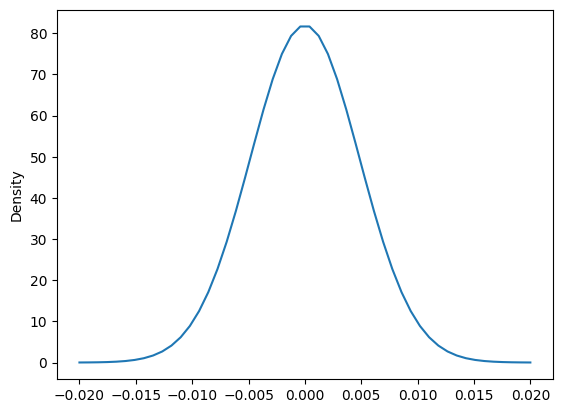

In [426]:
print(query_emb.obs["compartment_uncertainty"].mean(), np.quantile(query_emb.obs["compartment_uncertainty"], 0.75))
query_emb.obs["compartment_uncertainty"].plot(kind='density', ind=np.linspace(-0.02, 0.02))

In [427]:
def get_precision_recall(ground_truth: np.ndarray, pred: np.ndarray, do_round: bool = True):
    assert type(ground_truth) == np.ndarray and type(pred) == np.ndarray
    # https://stackoverflow.com/a/68157457
    tp = np.sum(np.logical_and(pred == 1, ground_truth == 1))
    fp = np.sum(np.logical_and(pred == 1, ground_truth == 0))
    fn = np.sum(np.logical_and(pred == 0, ground_truth == 1))
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    if precision == 0 and recall == 0:
        f1 = 0
    else:
        f1 = (2*precision*recall) / (precision+recall)
    if do_round:
        dec = 2
        return np.round(precision, dec), np.round(recall, dec), np.round(f1, dec)
    else:
        return precision, recall, f1
def binarize_array(arr, true_val: str) -> np.ndarray:
    v = [1 if val == true_val else 0 for val in arr]
    return np.array(v)

def evaluate_predictions(uncertainty_threshold = None):
    # build comparison_df
    assert metadata["compartment"].index.equals(query_emb.obs.index)
    comparison_df = pd.DataFrame(index=metadata["compartment"].index, columns=["pred", "ground_truth", "pred_uncertainty"])
    comparison_df["pred"] = query_emb.obs["compartment_pred"]
    comparison_df["pred_uncertainty"] = query_emb.obs["compartment_uncertainty"]
    comparison_df["ground_truth"] = metadata["compartment"].fillna(
                                                            "Unknown"
                                                        ).replace(
                                                            "stromal",
                                                            "stroma"
                                                        ).replace(
                                                            "lymphoid",
                                                            "immune"
                                                        ).replace(
                                                            "myeloid",
                                                            "immune"
                                                        ).str.capitalize()

    # we dont care about cases where we dont know the ground truth (in fact we could have skipped prediction for these altogether)
    n_before = len(comparison_df)
    comparison_df = comparison_df[comparison_df["ground_truth"] != "Unknown"]
    n_filtered = n_before-len(comparison_df)
    pct_filtered = 100*n_filtered/n_before
    print(f"filtered out {n_filtered} barcodes ({pct_filtered:.2f}%) with unknown ground truth")

    if uncertainty_threshold is not None:
        # filter out uncertainty > threshold
        n_before = len(comparison_df)
        comparison_df = comparison_df[comparison_df["pred_uncertainty"] <= uncertainty_threshold]
        n_filtered = n_before-len(comparison_df)
        pct_filtered = 100*n_filtered/n_before
        print(f"filtered out {n_filtered} barcodes ({pct_filtered:.2f}%) with pred uncertainty > {uncertainty_threshold}")

    # now calculate prediction accuracy
    match = comparison_df["pred"] == comparison_df["ground_truth"]
    accuracy = 100 * np.sum(match) / len(match)

    # compute F1 score for each predicted class
    unique_cats_pred = np.unique(comparison_df.pred)
    unique_cats_ground_truth = np.unique(comparison_df.ground_truth)
    # in our case this happens to be true but that's not always the case
    assert np.array_equal(unique_cats_pred, unique_cats_ground_truth)
    f1_scores = {}
    for cat in unique_cats_pred:
        binay_pred = binarize_array(comparison_df.pred, true_val=cat)
        binay_ground_truth = binarize_array(comparison_df.ground_truth, true_val=cat)
        f1_scores[cat] = get_precision_recall(binay_pred, binay_ground_truth)[2]

    return comparison_df, accuracy, f1_scores

In [294]:
comparison_df, accuracy, f1_scores = evaluate_predictions(uncertainty_threshold=0.2)
print(accuracy)
print(f1_scores)

filtered out 6 barcodes (0.34%) with unknown ground truth
filtered out 7 barcodes (0.39%) with pred uncertainty > 0.2
99.60518894529046
{'Endothelial': 1.0, 'Epithelial': 0.98, 'Immune': 0.99, 'Stroma': 1.0}


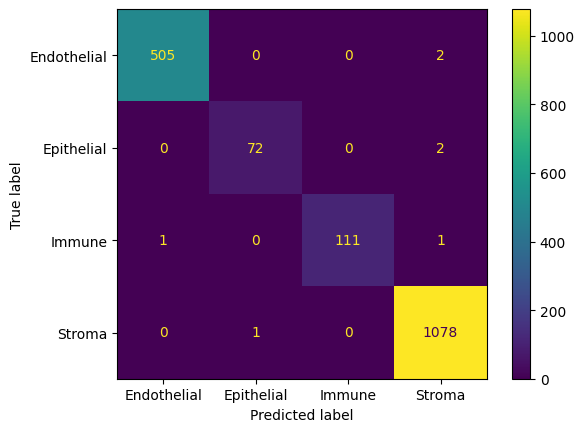

In [443]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(comparison_df["ground_truth"], comparison_df["pred"])

display_labels = list(f1_scores.keys())
cm_display = ConfusionMatrixDisplay(cm, display_labels=display_labels).plot()

## 4️⃣.2️⃣ Predict cell types

In [400]:
metadata["predicted_celltype"]

AAGCGTTTCAGTGCGC    lymphatic endothelial
AGCCACGAGGAGTCTG    lymphatic endothelial
ATCATTCGTATTTCGG    lymphatic endothelial
TGGCGTGCATGTAACC    lymphatic endothelial
CTACAGACACTGTGAT    lymphatic endothelial
                            ...          
TGATGCACATGGGCAA                      NaN
AATGACCAGCCGATTT                      NaN
CTCCATGCACTCTAGA                      NaN
ATGGGTTAGAGGCGTT                      NaN
CGTGTCTCACGCTGTG                      NaN
Name: predicted_celltype, Length: 1786, dtype: object

In [387]:
metadata["predicted_celltype"].value_counts()

myofibroblast            1031
vascular endothelial      415
lymphatic endothelial      97
AT1                        62
CD8+ T cell                57
pericyte                   28
club                       12
smc                        12
macrophage                 10
nkt                         8
fibroblast                  8
CD4+ T cell                 7
neutrophil                  7
plasma cell                 7
mast                        6
NK cell                     4
Treg                        3
B cell                      2
cDC                         2
AT2                         2
Name: predicted_celltype, dtype: int64

In [399]:
# model_latent.adata.obs["scanvi_label"].value_counts()
model_latent.adata.obs["core_ann_level_3"].value_counts()
# model_latent.adata.obs["original_ann_level_3"].value_counts()

Macrophages                     111844
Basal                            84713
Secretory                        80557
AT2                              62175
T cell lineage                   50859
Multiciliated lineage            41098
Monocytes                        26529
EC capillary                     23205
Fibroblasts                      20384
Innate lymphoid cell NK          16978
EC venous                        12975
Dendritic cells                  10319
AT1                               7937
EC arterial                       7391
Mast cells                        6623
B cell lineage                    6284
Submucosal Secretory              4700
Lymphatic EC mature               4001
None                              3226
Rare                               885
Myofibroblasts                     716
Lymphatic EC differentiating       566
SM activated stress response       556
Fibromyocytes                      335
Lymphatic EC proliferating          28
Name: core_ann_level_3, d

In [392]:
label_key = "core_ann_level_3"
ref_cats = model_latent.adata.obs[label_key].cat.codes.to_numpy()[ref_neighbors]
p, u = weighted_prediction(weights, ref_cats)
p = np.asarray(model_latent.adata.obs[label_key].cat.categories)[p]
query_emb.obs["celltype_pred"], query_emb.obs["celltype_uncertainty"] = p, u

0.033202483465797024 5.960464477539063e-08


<AxesSubplot: ylabel='Density'>

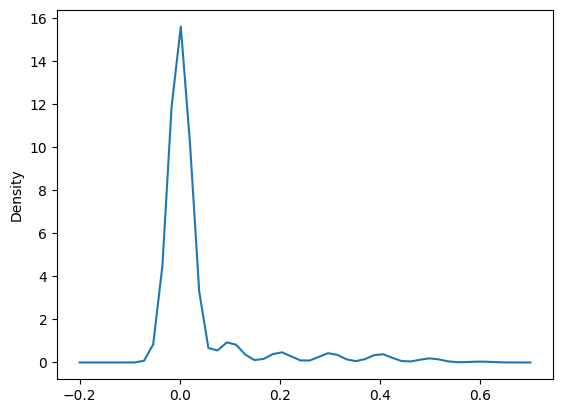

In [398]:
print(query_emb.obs["celltype_uncertainty"].mean(), np.quantile(query_emb.obs["celltype_uncertainty"], 0.75))
query_emb.obs["celltype_uncertainty"].plot(kind='density', ind=np.linspace(-0.2, 0.7))

In [406]:
# mostly a copy and paste of the function above but that's ok for now
def evaluate_cell_type_predictions(uncertainty_threshold = None):
    # build comparison_df
    assert metadata["predicted_celltype"].index.equals(query_emb.obs.index)
    comparison_df = pd.DataFrame(index=metadata["predicted_celltype"].index, columns=["pred", "ground_truth", "pred_uncertainty"])
    comparison_df["pred"] = query_emb.obs["celltype_pred"]
    comparison_df["pred_uncertainty"] = query_emb.obs["celltype_uncertainty"]
    comparison_df["ground_truth"] = metadata["predicted_celltype"].fillna(
                                                            "Unknown"
                                                        # ).replace(
                                                        #     "myeloid",
                                                        #     "immune"
                                                        ).str.capitalize()

    # we dont care about cases where we dont know the ground truth (in fact we could have skipped prediction for these altogether)
    n_before = len(comparison_df)
    comparison_df = comparison_df[comparison_df["ground_truth"] != "Unknown"]
    n_filtered = n_before-len(comparison_df)
    pct_filtered = 100*n_filtered/n_before
    print(f"filtered out {n_filtered} barcodes ({pct_filtered:.2f}%) with unknown ground truth")

    if uncertainty_threshold is not None:
        # filter out uncertainty > threshold
        n_before = len(comparison_df)
        comparison_df = comparison_df[comparison_df["pred_uncertainty"] <= uncertainty_threshold]
        n_filtered = n_before-len(comparison_df)
        pct_filtered = 100*n_filtered/n_before
        print(f"filtered out {n_filtered} barcodes ({pct_filtered:.2f}%) with pred uncertainty > {uncertainty_threshold}")

    # now calculate prediction accuracy
    match = comparison_df["pred"] == comparison_df["ground_truth"]
    accuracy = 100 * np.sum(match) / len(match)

    # # compute F1 score for each predicted class
    # unique_cats_pred = np.unique(comparison_df.pred)
    # unique_cats_ground_truth = np.unique(comparison_df.ground_truth)
    # # in our case this happens to be true but that's not always the case
    # assert np.array_equal(unique_cats_pred, unique_cats_ground_truth)
    # f1_scores = {}
    # for cat in unique_cats_pred:
    #     binay_pred = binarize_array(comparison_df.pred, true_val=cat)
    #     binay_ground_truth = binarize_array(comparison_df.ground_truth, true_val=cat)
    #     f1_scores[cat] = get_precision_recall(binay_pred, binay_ground_truth)[2]

    return comparison_df, accuracy

In [408]:
comparison_df, accuracy = evaluate_cell_type_predictions(uncertainty_threshold=0.2)
print(accuracy)

filtered out 6 barcodes (0.34%) with unknown ground truth
filtered out 126 barcodes (7.08%) with pred uncertainty > 0.2
0.0


In [412]:
comparison_df[comparison_df["pred"] != comparison_df["ground_truth"]][:20]

,pred,ground_truth,pred_uncertainty
TGGCGTGCATGTAACC,Lymphatic EC mature,Lymphatic endothelial,9.999728e-02
CTACAGACACTGTGAT,EC venous,Lymphatic endothelial,0.000000e+00
GGGTAGATCGTGGAAG,Lymphatic EC mature,Lymphatic endothelial,1.999955e-01
TTTCCTCAGGACCCAA,Lymphatic EC differentiating,Lymphatic endothelial,0.000000e+00
CAAGACTGTGACCGAA,Lymphatic EC differentiating,Lymphatic endothelial,0.000000e+00
GGAATGGGTGCTGCAC,EC venous,Lymphatic endothelial,0.000000e+00
AGTCACAGTCACTGAT,Lymphatic EC mature,Lymphatic endothelial,9.999001e-02
CCTCATGCACAAGTTC,Lymphatic EC differentiating,Lymphatic endothelial,5.960464e-08
GCCCAGAGTCAGACTT,Lymphatic EC mature,Lymphatic endothelial,1.000052e-01
CATACAGAGGGTTGCA,Lymphatic EC differentiating,Lymphatic endothelial,9.999418e-02


## 5️⃣ Visualize embeddings in the joint latent space

Combine embeddings

In [308]:
query_emb.obs["dataset"] = "test_dataset_delorey_regev"
query_emb

AnnData object with n_obs × n_vars = 1786 × 30
    obs: 'compartment_pred', 'compartment_uncertainty', 'dataset'

In [368]:
reference_emb = sc.AnnData(model_latent.adata.obsm["X_latent_qzm"])
reference_emb.obs_names = model_latent.adata.obs_names
reference_emb.obs["dataset"] = model_latent.adata.obs.dataset
reference_emb

AnnData object with n_obs × n_vars = 584884 × 30
    obs: 'dataset'

In [309]:
combined_emb = reference_emb.concatenate(query_emb)

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [313]:
combined_emb.obs["batch"].value_counts()

0    584884
1      1786
Name: batch, dtype: int64

Visualize embeddings.  

We could use pymde here but it is failing to pip install -_- So for now we will visualize a subset of the cells to reduce runtime of umap.   

Since there are too many cells from the reference, we cannot see the query cells very well on the UMAP. So let's plot a random subset of the reference cells, plus all the query cells.

In [369]:
# n_cells = int(np.floor(0.5 * combined_emb.n_obs))
# idx = np.random.choice(range(combined_emb.n_obs), n_cells, replace=False)
# combined_emb_subset = combined_emb[idx, :].copy()

# # Make sure that proportions of query vs reference cells wasn't significantly altered post subsetting.
# r = combined_emb.obs["batch"].value_counts()[0]
# q = combined_emb.obs["batch"].value_counts()[1]

# r_ss = combined_emb_subset.obs["batch"].value_counts()[0]
# q_ss = combined_emb_subset.obs["batch"].value_counts()[1]

# print(100*q/r, 100*q_ss/r_ss)

In [377]:
query_cells = combined_emb[combined_emb.obs.batch == "1", :].copy()

ref_cells = combined_emb[combined_emb.obs.batch == "0", :].copy()
n_cells_ref = int(np.floor(0.09 * ref_cells.n_obs))
idx = np.random.choice(range(ref_cells.n_obs), n_cells_ref, replace=False)
ref_cells_subset = ref_cells[idx, :].copy()

combined_emb_subset = ref_cells_subset.concatenate(query_cells)
print(combined_emb.n_obs / combined_emb_subset.n_obs)

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


10.779421221864952


In [378]:
sc.pp.neighbors(combined_emb_subset, use_rep="X")

In [379]:
sc.tl.umap(combined_emb_subset, min_dist=0.3)

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


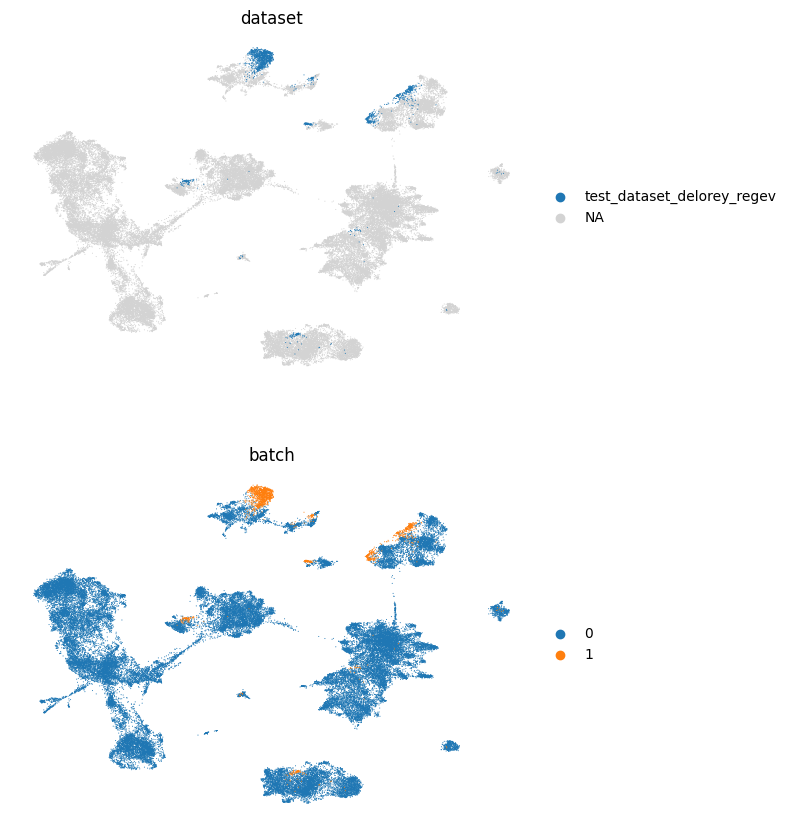

In [380]:
sc.pl.umap(
    combined_emb_subset,
    color=["dataset", "batch"],
    ncols=1,
    frameon=False,
)